In [ ]:
#https://www.kaggle.com/isaienkov/ingv-volcanic-eruption-prediction-eda-modeling/notebook
#https://www.kaggle.com/jesperdramsch/introduction-to-volcanology-seismograms-and-lgbm/data
#https://www.kaggle.com/deepakbhatp/ingv-spectraldensity-stft-pca-xgb-stratifiedkfold


In [2]:
#import libraries
import os
import glob
import numpy as np
import pandas as pd
import scipy
import scipy.signal
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_selection import RFE
from rgf.sklearn import RGFRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgbm
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split,KFold
import optuna
from optuna.samplers import TPESampler

In [3]:
os.chdir("../input/predict-volcanic-eruptions-ingv-oe")
print(os.getcwd())

/kaggle/input/predict-volcanic-eruptions-ingv-oe


# Data Overview

In [4]:
train=pd.read_csv('train.csv')
test=pd.read_csv("sample_submission.csv")

In [5]:
train_files=glob.glob("train/*")
print("Number of train files: "+str(len(train_files)))
test_files=glob.glob("test/*")
print("Number of test files: "+str(len(test_files)))

Number of train files: 4431
Number of test files: 4520


# Modeling

In [6]:
#https://www.kaggle.com/isaienkov/ingv-volcanic-eruption-prediction-eda-modeling/notebook
def make_statistic_features(signal, ts, sensor_id):#signalは縦のcolumn
    X=pd.DataFrame()    
    X.loc[ts, f'{sensor_id}_std']       = signal.std()
    X.loc[ts, f'{sensor_id}_max']       = signal.max()
    X.loc[ts, f'{sensor_id}_min']       = signal.min()
    X.loc[ts, f'{sensor_id}_mad']       = signal.mad()
    X.loc[ts, f'{sensor_id}_skew']      = signal.skew()
    X.loc[ts, f'{sensor_id}_kurtosis']  = signal.kurtosis()
    X.loc[ts, f'{sensor_id}_quantile99']= np.quantile(signal, 0.99)
    X.loc[ts, f'{sensor_id}_quantile75']= np.quantile(signal, 0.75)
    X.loc[ts, f'{sensor_id}_quantile25']= np.quantile(signal, 0.25)
    X.loc[ts, f'{sensor_id}_quantile01']= np.quantile(signal, 0.01)
    
    return X

In [7]:
train_stats=[]
for train_file in tqdm(train_files):
    signals=pd.read_csv(train_file)
    train_row=[]
    for i in range(1,11):
        sensor_id="sensor_"+str(i)
        train_row.append(make_statistic_features(signals[sensor_id].fillna(0),train_file.split("/")[1].split(".")[0], sensor_id))
    train_row=pd.concat(train_row, axis=1)
    train_stats.append(train_row)

train_stats=pd.concat(train_stats)

100%|██████████| 4431/4431 [21:34<00:00,  3.42it/s]


In [8]:
train_stats=train_stats.reset_index()
train_stats=train_stats.rename(columns={"index":"segment_id"})
train_stats["segment_id"]=train_stats["segment_id"].apply(int)
train_stats.head()

,segment_id,sensor_1_std,sensor_1_max,sensor_1_min,sensor_1_mad,sensor_1_skew,sensor_1_kurtosis,sensor_1_quantile99,sensor_1_quantile75,sensor_1_quantile25,...,sensor_10_std,sensor_10_max,sensor_10_min,sensor_10_mad,sensor_10_skew,sensor_10_kurtosis,sensor_10_quantile99,sensor_10_quantile75,sensor_10_quantile25,sensor_10_quantile01
0,800654756,470.544946,4065.0,-3891.0,348.802605,0.210301,5.531386,1109.0,286.0,-273.0,...,927.946272,10389.0,-10709.0,637.528596,-0.219034,11.990491,2485.0,487.0,-473.0,-2273.0
1,321543978,584.061135,2610.0,-2165.0,460.779468,0.006554,0.266137,1407.0,383.0,-382.0,...,943.025870,4744.0,-4234.0,738.193405,0.014998,0.510147,2239.0,607.0,-609.0,-2302.0
2,1417547769,262.683950,1435.0,-1242.0,202.104232,0.074322,1.083767,680.0,164.0,-163.0,...,541.124992,3404.0,-3299.0,412.379406,-0.010506,1.433292,1362.0,325.0,-327.0,-1373.0
3,729870090,598.164998,2370.0,-2310.0,483.291742,-0.009542,-0.180992,1349.0,417.0,-428.0,...,1151.489774,4738.0,-4398.0,924.142733,0.045532,-0.079585,2678.0,808.0,-780.0,-2571.0
4,830695026,399.197472,3812.0,-2717.0,279.638276,0.351822,8.513519,1044.0,208.0,-213.0,...,699.036865,4774.0,-4081.0,518.552127,0.272216,3.026823,1902.0,404.0,-407.0,-1747.0


In [9]:
import pickle
with open("/kaggle/working/train_stats.pkl","wb") as f:
    pickle.dump(train_stats,f)

In [10]:
#フーリエ変換とは、時間の関数である波形を周波数の関数であるスペクトルに変換する
#実数部は振幅、虚数部は位相。パワーは振幅の二乗に比例する。実部の方が重

#STFT(Short Time Fourier Transformation) Specificatins
fs=100 #sampling frequency
N = len(train_files[0])     # data size get the number of rows
n = 256                 # FFT segment size
max_f = 20              # ～20Hz

delta_f = fs / n        # 0.39Hz
delta_t = n / fs / 2    # 1.28s

In [11]:
#https://www.kaggle.com/amanooo/ingv-volcanic-basic-solution-stft

def make_features(tgt):
    tgt_df = train if tgt == 'train' else test
    feature_set = []
    for segment_id in tqdm(tgt_df['segment_id']):
        segment_df = pd.read_csv(tgt+"/"+str(segment_id)+".csv")
        segment = [segment_id]
        for sensor in segment_df.columns:
            x = segment_df[sensor][:N]
            if x.isna().sum() > 1000:     ##########
                segment += ([np.NaN] * 10)
                continue
            f, t, Z = scipy.signal.stft(x.fillna(0), fs = fs, window = 'hann', nperseg = n)
            f = f[:round(max_f/delta_f)+1]
            Z = np.abs(Z[:round(max_f/delta_f)+1]).T    # ～max_f, row:time,col:freq

            th = Z.mean() * 1     ##########
            Z_pow = Z.copy()
            Z_pow[Z < th] = 0
            Z_num = Z_pow.copy()
            Z_num[Z >= th] = 1

            Z_pow_sum = Z_pow.sum(axis = 0)
            Z_num_sum = Z_num.sum(axis = 0)

            A_pow = Z_pow_sum[round(10/delta_f):].sum()
            A_num = Z_num_sum[round(10/delta_f):].sum()
            BH_pow = Z_pow_sum[round(5/delta_f):round(8/delta_f)].sum()
            BH_num = Z_num_sum[round(5/delta_f):round(8/delta_f)].sum()
            BL_pow = Z_pow_sum[round(1.5/delta_f):round(2.5/delta_f)].sum()
            BL_num = Z_num_sum[round(1.5/delta_f):round(2.5/delta_f)].sum()
            C_pow = Z_pow_sum[round(0.6/delta_f):round(1.2/delta_f)].sum()
            C_num = Z_num_sum[round(0.6/delta_f):round(1.2/delta_f)].sum()
            D_pow = Z_pow_sum[round(2/delta_f):round(4/delta_f)].sum()
            D_num = Z_num_sum[round(2/delta_f):round(4/delta_f)].sum()
            segment += [A_pow, A_num, BH_pow, BH_num, BL_pow, BL_num, C_pow, C_num, D_pow, D_num]

        feature_set.append(segment)

    cols = ['segment_id']
    for i in range(10):
        for j in ['A_pow', 'A_num','BH_pow', 'BH_num','BL_pow', 'BL_num','C_pow', 'C_num','D_pow', 'D_num']:
            cols += [f's{i+1}_{j}']
    feature_df = pd.DataFrame(feature_set, columns = cols)
    feature_df['segment_id'] = feature_df['segment_id'].astype('int')
    return feature_df

In [12]:
import scipy.signal
feature_df = make_features('train')
train_stft = pd.merge(train, feature_df, on = 'segment_id')
train_stft.head()

  0%|          | 0/4431 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 19, using nperseg = 19
  .format(nperseg, input_length))
100%|██████████| 4431/4431 [07:39<00:00,  9.64it/s]


,segment_id,time_to_eruption,s1_A_pow,s1_A_num,s1_BH_pow,s1_BH_num,s1_BL_pow,s1_BL_num,s1_C_pow,s1_C_num,...,s10_A_pow,s10_A_num,s10_BH_pow,s10_BH_num,s10_BL_pow,s10_BL_num,s10_C_pow,s10_C_num,s10_D_pow,s10_D_num
0,1136037770,12262005,0.0,0.0,0.0,0.0,0.0,0.0,65.433276,2.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,151.331709,1.0,0.000000,0.0
1,1969647810,32739612,0.0,0.0,0.0,0.0,0.0,0.0,64.051961,1.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,508.296281,3.0,0.000000,0.0
2,1895879680,14965999,0.0,0.0,0.0,0.0,0.0,0.0,86.833624,3.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,132.023897,3.0,0.000000,0.0
3,2068207140,26469720,0.0,0.0,0.0,0.0,0.0,0.0,62.759196,3.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,92.609337,1.0,0.000000,0.0
4,192955606,31072429,0.0,0.0,0.0,0.0,0.0,0.0,116.165074,2.0,...,0.0,0.0,0.0,0.0,50.152455,2.0,100.005924,2.0,21.824738,1.0


In [13]:
with open("/kaggle/working/train_stft.pkl","wb") as f:
    pickle.dump(train_stft,f)

In [14]:
tmp=pd.merge(train_stats, train, on="segment_id")
tmp.head()

,segment_id,sensor_1_std,sensor_1_max,sensor_1_min,sensor_1_mad,sensor_1_skew,sensor_1_kurtosis,sensor_1_quantile99,sensor_1_quantile75,sensor_1_quantile25,...,sensor_10_max,sensor_10_min,sensor_10_mad,sensor_10_skew,sensor_10_kurtosis,sensor_10_quantile99,sensor_10_quantile75,sensor_10_quantile25,sensor_10_quantile01,time_to_eruption
0,800654756,470.544946,4065.0,-3891.0,348.802605,0.210301,5.531386,1109.0,286.0,-273.0,...,10389.0,-10709.0,637.528596,-0.219034,11.990491,2485.0,487.0,-473.0,-2273.0,16818516
1,321543978,584.061135,2610.0,-2165.0,460.779468,0.006554,0.266137,1407.0,383.0,-382.0,...,4744.0,-4234.0,738.193405,0.014998,0.510147,2239.0,607.0,-609.0,-2302.0,10340827
2,1417547769,262.683950,1435.0,-1242.0,202.104232,0.074322,1.083767,680.0,164.0,-163.0,...,3404.0,-3299.0,412.379406,-0.010506,1.433292,1362.0,325.0,-327.0,-1373.0,40087733
3,729870090,598.164998,2370.0,-2310.0,483.291742,-0.009542,-0.180992,1349.0,417.0,-428.0,...,4738.0,-4398.0,924.142733,0.045532,-0.079585,2678.0,808.0,-780.0,-2571.0,31317486
4,830695026,399.197472,3812.0,-2717.0,279.638276,0.351822,8.513519,1044.0,208.0,-213.0,...,4774.0,-4081.0,518.552127,0.272216,3.026823,1902.0,404.0,-407.0,-1747.0,5801334


In [15]:
train_set=pd.merge(tmp,train_stft, on="segment_id")
train_set.head()

,segment_id,sensor_1_std,sensor_1_max,sensor_1_min,sensor_1_mad,sensor_1_skew,sensor_1_kurtosis,sensor_1_quantile99,sensor_1_quantile75,sensor_1_quantile25,...,s10_A_pow,s10_A_num,s10_BH_pow,s10_BH_num,s10_BL_pow,s10_BL_num,s10_C_pow,s10_C_num,s10_D_pow,s10_D_num
0,800654756,470.544946,4065.0,-3891.0,348.802605,0.210301,5.531386,1109.0,286.0,-273.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,197.161038,2.0,0.0,0.0
1,321543978,584.061135,2610.0,-2165.0,460.779468,0.006554,0.266137,1407.0,383.0,-382.0,...,0.0,0.0,0.0,0.0,61.477466,1.0,250.125701,3.0,0.0,0.0
2,1417547769,262.683950,1435.0,-1242.0,202.104232,0.074322,1.083767,680.0,164.0,-163.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,231.020098,2.0,0.0,0.0
3,729870090,598.164998,2370.0,-2310.0,483.291742,-0.009542,-0.180992,1349.0,417.0,-428.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
4,830695026,399.197472,3812.0,-2717.0,279.638276,0.351822,8.513519,1044.0,208.0,-213.0,...,0.0,0.0,0.0,0.0,40.092112,1.0,103.922406,1.0,0.0,0.0


In [30]:
list(train_set.columns)

['segment_id',
 'sensor_1_std',
 'sensor_1_max',
 'sensor_1_min',
 'sensor_1_mad',
 'sensor_1_skew',
 'sensor_1_kurtosis',
 'sensor_1_quantile99',
 'sensor_1_quantile75',
 'sensor_1_quantile25',
 'sensor_1_quantile01',
 'sensor_2_std',
 'sensor_2_max',
 'sensor_2_min',
 'sensor_2_mad',
 'sensor_2_skew',
 'sensor_2_kurtosis',
 'sensor_2_quantile99',
 'sensor_2_quantile75',
 'sensor_2_quantile25',
 'sensor_2_quantile01',
 'sensor_3_std',
 'sensor_3_max',
 'sensor_3_min',
 'sensor_3_mad',
 'sensor_3_skew',
 'sensor_3_kurtosis',
 'sensor_3_quantile99',
 'sensor_3_quantile75',
 'sensor_3_quantile25',
 'sensor_3_quantile01',
 'sensor_4_std',
 'sensor_4_max',
 'sensor_4_min',
 'sensor_4_mad',
 'sensor_4_skew',
 'sensor_4_kurtosis',
 'sensor_4_quantile99',
 'sensor_4_quantile75',
 'sensor_4_quantile25',
 'sensor_4_quantile01',
 'sensor_5_std',
 'sensor_5_max',
 'sensor_5_min',
 'sensor_5_mad',
 'sensor_5_skew',
 'sensor_5_kurtosis',
 'sensor_5_quantile99',
 'sensor_5_quantile75',
 'sensor_5_qu

In [29]:
train_set=train_set.rename(columns={"time_to_eruption_x":"time_to_eruption"})

KeyError: "['time_to_eruption_y'] not found in axis"

In [31]:
train_set=train_set.drop("time_to_eruption_y", axis=1)#axis=1をわすれるなよ
train_set.head()

,segment_id,sensor_1_std,sensor_1_max,sensor_1_min,sensor_1_mad,sensor_1_skew,sensor_1_kurtosis,sensor_1_quantile99,sensor_1_quantile75,sensor_1_quantile25,...,s10_A_pow,s10_A_num,s10_BH_pow,s10_BH_num,s10_BL_pow,s10_BL_num,s10_C_pow,s10_C_num,s10_D_pow,s10_D_num
0,800654756,470.544946,4065.0,-3891.0,348.802605,0.210301,5.531386,1109.0,286.0,-273.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,197.161038,2.0,0.0,0.0
1,321543978,584.061135,2610.0,-2165.0,460.779468,0.006554,0.266137,1407.0,383.0,-382.0,...,0.0,0.0,0.0,0.0,61.477466,1.0,250.125701,3.0,0.0,0.0
2,1417547769,262.683950,1435.0,-1242.0,202.104232,0.074322,1.083767,680.0,164.0,-163.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,231.020098,2.0,0.0,0.0
3,729870090,598.164998,2370.0,-2310.0,483.291742,-0.009542,-0.180992,1349.0,417.0,-428.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
4,830695026,399.197472,3812.0,-2717.0,279.638276,0.351822,8.513519,1044.0,208.0,-213.0,...,0.0,0.0,0.0,0.0,40.092112,1.0,103.922406,1.0,0.0,0.0


In [32]:
with open("/kaggle/working/train_set.pkl","wb") as f:
    pickle.dump(train_set,f)

In [33]:
X=train_set[train_set.columns.drop("time_to_eruption")]
y=train_set["time_to_eruption"]

In [35]:
!pip install Borutashap

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [38]:
#https://www.kaggle.com/carlmcbrideellis/volcanic-feature-importance-using-boruta-shap
from BorutaShap import BorutaShap
model=lgbm.LGBMRegressor()
Feature_Selector=BorutaShap(model=model,importance_measure="shap", classification=False)
Feature_Selector.fit(X=X,y=y,n_trials=35,random_state=0)

100%|██████████| 35/35 [02:59<00:00,  5.14s/it]

41 attributes confirmed important: ['sensor_4_quantile25', 'sensor_8_quantile99', 'sensor_9_quantile01', 'sensor_2_kurtosis', 'sensor_9_quantile99', 'sensor_1_max', 'sensor_9_kurtosis', 'sensor_6_quantile01', 'sensor_5_std', 'sensor_10_quantile01', 's5_BL_num', 's2_D_num', 'sensor_6_quantile25', 'sensor_2_quantile25', 'sensor_8_quantile75', 'sensor_10_quantile25', 'sensor_6_quantile75', 'sensor_6_kurtosis', 's5_D_pow', 'sensor_10_kurtosis', 'sensor_1_quantile25', 'sensor_2_min', 'sensor_2_mad', 'sensor_3_quantile25', 'sensor_5_quantile01', 'sensor_1_min', 'sensor_3_max', 'sensor_5_quantile75', 'sensor_10_quantile75', 's3_C_pow', 'sensor_1_quantile75', 'sensor_5_quantile25', 's1_D_num', 'sensor_9_max', 'sensor_6_min', 'sensor_2_quantile01', 'sensor_3_min', 'sensor_8_std', 'sensor_2_quantile99', 'sensor_3_quantile75', 's2_C_pow']
135 attributes confirmed unimportant: ['s4_BL_pow', 'sensor_2_skew', 's3_BL_num', 's3_BH_pow', 'sensor_6_skew', 's7_D_num', 's5_C_pow', 's5_C_num', 's1_BL_pow',

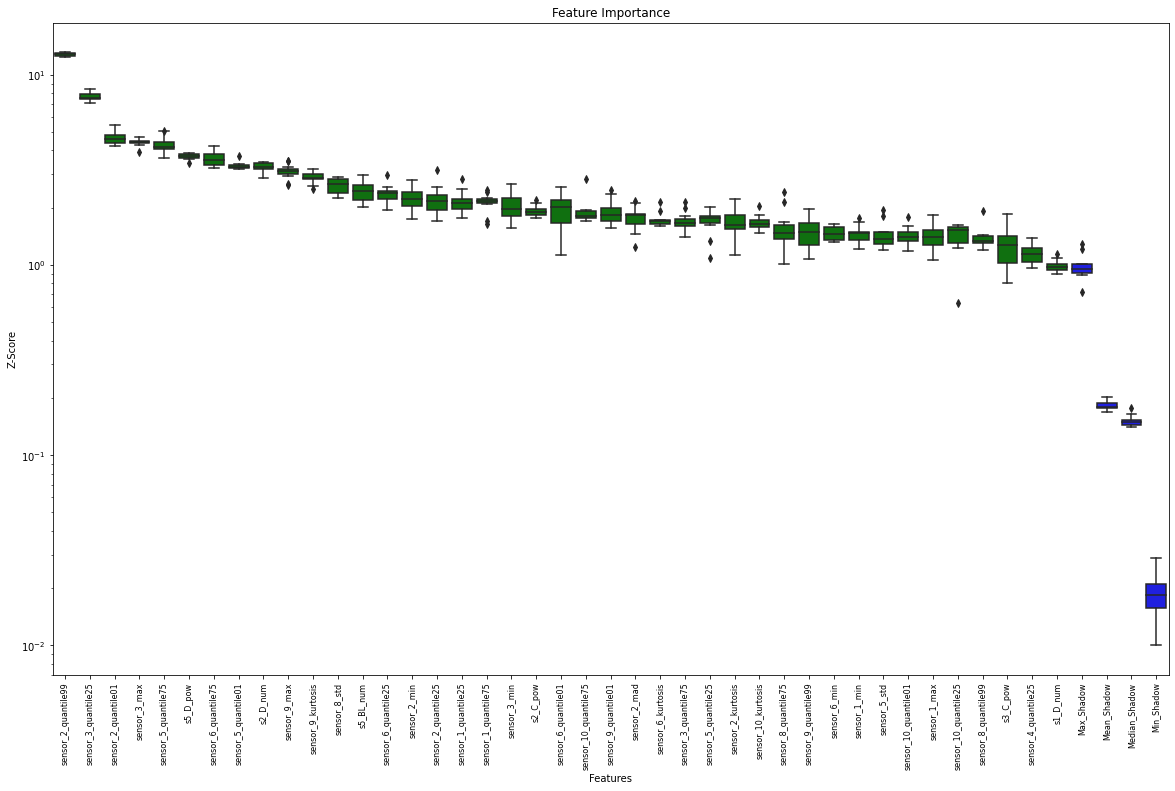

In [39]:
Feature_Selector.plot(which_features='accepted', figsize=(20,12))

In [42]:
selected_features = Feature_Selector.Subset()
selected_columns=list(selected_features.columns)

['sensor_4_quantile25',
 'sensor_8_quantile99',
 'sensor_9_quantile01',
 'sensor_2_kurtosis',
 'sensor_9_quantile99',
 'sensor_1_max',
 'sensor_9_kurtosis',
 'sensor_6_quantile01',
 'sensor_5_std',
 'sensor_10_quantile01',
 's5_BL_num',
 's2_D_num',
 'sensor_6_quantile25',
 'sensor_2_quantile25',
 'sensor_8_quantile75',
 'sensor_10_quantile25',
 'sensor_6_quantile75',
 'sensor_6_kurtosis',
 's5_D_pow',
 'sensor_10_kurtosis',
 'sensor_1_quantile25',
 'sensor_2_min',
 'sensor_2_mad',
 'sensor_3_quantile25',
 'sensor_5_quantile01',
 'sensor_1_min',
 'sensor_3_max',
 'sensor_5_quantile75',
 'sensor_10_quantile75',
 's3_C_pow',
 'sensor_1_quantile75',
 'sensor_5_quantile25',
 's1_D_num',
 'sensor_9_max',
 'sensor_6_min',
 'sensor_2_quantile01',
 'sensor_3_min',
 'sensor_8_std',
 'sensor_2_quantile99',
 'sensor_3_quantile75',
 's2_C_pow']

In [44]:
X=X[selected_columns]#BorutaShapで有効だと判断されたカラムだけ

In [45]:
#train/validation/test=70%/15%/15%
train_x, test_x, train_y, test_y=train_test_split(X,y,random_state=42, test_size=0.15,shuffle=True)
train_x, val_x, train_y, val_y=train_test_split(train_x,train_y,random_state=42, test_size=0.17,shuffle=True)

In [46]:
#LGBMRegressor + optuna
sampler=TPESampler(seed=42)

def create_model_lgbm(trial):
    num_leaves=trial.suggest_int("num_leaves",2,31)
    n_estimators=trial.suggest_int("n_estimators",50,300)
    max_depth=trial.suggest_int("max_depth",3,8)
    min_child_samples=trial.suggest_int("min_child_samples",100,1200)
    learning_rate=trial.suggest_uniform("learning_rate",0.0001,0.99)
    min_data_in_leaf=trial.suggest_int('min_data_in_leaf',5,90)
    feature_fraction=trial.suggest_uniform('feature_fraction',0.0001,1.0)
    
    model=lgbm.LGBMRegressor(
    num_leaves=num_leaves,
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_child_samples=min_child_samples,
    min_data_in_leaf=min_data_in_leaf,
    learning_rate=learning_rate,
    feature_fraction=feature_fraction,
    random_state=42)
    
    return model


#目的関数
def objective_lgbm(trial):
    model=create_model_lgbm(trial)
    model.fit(train_x,train_y)
    preds=model.predict(val_x)
    score=mean_absolute_error(val_y,preds)
    return score


study=optuna.create_study(direction="minimize", sampler=sampler)
optuna.logging.disable_default_handler()#don't show log
study.optimize(objective_lgbm, n_trials=100)


#最適解
print(study.best_params)
print(study.best_value)
#print(study.best_trial)

[I 2021-01-01 07:16:52,775] A new study created in memory with name: no-name-347e011c-63ac-461c-aff4-4b437b8e95db


{'num_leaves': 31, 'n_estimators': 255, 'max_depth': 8, 'min_child_samples': 1117, 'learning_rate': 0.12719891029513516, 'min_data_in_leaf': 15, 'feature_fraction': 0.4746773312278301}
4194398.472791596


In [47]:
#check
params_lgbm= study.best_params

model=lgbm.LGBMRegressor(**params_lgbm)
model.fit(train_x, train_y)
preds=model.predict(test_x)
print('test LGB model mean_squared_error: ', mean_absolute_error(test_y, preds))#over-fitting?

test LGB model mean_squared_error:  4214600.340764483


# Submission

In [48]:
test_stats=[]
for test_file in tqdm(test_files):
    signals=pd.read_csv(test_file)
    test_row=[]
    for i in range(1,11):
        sensor_id="sensor_"+str(i)
        test_row.append(make_statistic_features(signals[sensor_id].fillna(0),test_file.split("/")[1].split(".")[0], sensor_id))
    test_row=pd.concat(test_row, axis=1)
    test_stats.append(test_row)

test_stats=pd.concat(test_stats)

100%|██████████| 4520/4520 [21:49<00:00,  3.45it/s]


In [ ]:
test_stats=test_stats.reset_index()
test_stats=test_stats.rename(columns={"index":"segment_id"})
test_stats["segment_id"]=test_stats["segment_id"].apply(int)
test_stats.head()

In [55]:
test_stats.head()

,segment_id,sensor_1_std,sensor_1_max,sensor_1_min,sensor_1_mad,sensor_1_skew,sensor_1_kurtosis,sensor_1_quantile99,sensor_1_quantile75,sensor_1_quantile25,...,sensor_10_std,sensor_10_max,sensor_10_min,sensor_10_mad,sensor_10_skew,sensor_10_kurtosis,sensor_10_quantile99,sensor_10_quantile75,sensor_10_quantile25,sensor_10_quantile01
0,473253715,469.553705,1768.0,-2035.0,371.762610,0.008376,0.170257,1119.0,313.0,-313.0,...,816.403053,4750.0,-3401.0,643.167796,-0.022185,0.311241,1921.0,535.0,-536.0,-1995.0
1,698018079,324.254991,1884.0,-2101.0,250.818417,-0.075053,1.160786,785.0,205.0,-207.0,...,674.661328,4182.0,-4645.0,503.587355,0.029887,2.389208,1794.0,392.0,-392.0,-1696.0
2,1102809614,187.078093,811.0,-830.0,147.487040,-0.048817,0.256339,435.0,123.0,-122.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
3,1087681649,220.053325,904.0,-1078.0,174.231944,0.022154,0.188954,527.0,144.0,-146.0,...,489.441286,2293.0,-2167.0,388.497742,-0.049564,0.168186,1128.0,319.0,-335.0,-1186.0
4,1939361933,257.255088,1681.0,-2004.0,189.118104,-0.195039,3.527613,659.0,144.0,-146.0,...,570.801427,4411.0,-4229.0,413.067261,-0.082429,4.527737,1515.0,313.0,-314.0,-1539.0


In [51]:
with open("/kaggle/working/test_stats.pkl","wb") as f:
    pickle.dump(test_stats,f)

In [52]:
test_stft= make_features('test')
test_stft.head()

100%|██████████| 4520/4520 [07:28<00:00, 10.09it/s]


,segment_id,s1_A_pow,s1_A_num,s1_BH_pow,s1_BH_num,s1_BL_pow,s1_BL_num,s1_C_pow,s1_C_num,s1_D_pow,...,s10_A_pow,s10_A_num,s10_BH_pow,s10_BH_num,s10_BL_pow,s10_BL_num,s10_C_pow,s10_C_num,s10_D_pow,s10_D_num
0,1000213997,0.0,0.0,0.0,0.0,0.000000,0.0,78.633106,2.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,6.0,0.000000,3.0,0.0,15.0
1,100023368,0.0,0.0,0.0,0.0,0.000000,0.0,205.015274,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,104.050183,1.0,0.0,0.0
2,1000488999,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,230.622501,...,0.0,0.0,0.0,0.0,0.0,6.0,0.000000,3.0,0.0,15.0
3,1001028887,0.0,0.0,0.0,0.0,0.000000,0.0,125.774697,2.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,6.0,0.000000,3.0,0.0,15.0
4,1001857862,0.0,0.0,0.0,0.0,36.407456,1.0,73.457356,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,127.997551,2.0,0.0,0.0


In [53]:
with open("/kaggle/working/test_stft.pkl","wb") as f:
    pickle.dump(test_stft,f)

In [73]:
test_set=pd.merge(test_stats,test_stft, on="segment_id")
test_set.head()

,segment_id,sensor_1_std,sensor_1_max,sensor_1_min,sensor_1_mad,sensor_1_skew,sensor_1_kurtosis,sensor_1_quantile99,sensor_1_quantile75,sensor_1_quantile25,...,s10_A_pow,s10_A_num,s10_BH_pow,s10_BH_num,s10_BL_pow,s10_BL_num,s10_C_pow,s10_C_num,s10_D_pow,s10_D_num
0,473253715,469.553705,1768.0,-2035.0,371.762610,0.008376,0.170257,1119.0,313.0,-313.0,...,0.0,0.0,0.0,0.0,92.283028,2.0,141.630180,2.0,76.513103,2.0
1,698018079,324.254991,1884.0,-2101.0,250.818417,-0.075053,1.160786,785.0,205.0,-207.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,232.681286,3.0,0.000000,0.0
2,1102809614,187.078093,811.0,-830.0,147.487040,-0.048817,0.256339,435.0,123.0,-122.0,...,0.0,0.0,0.0,0.0,0.000000,6.0,0.000000,3.0,0.000000,15.0
3,1087681649,220.053325,904.0,-1078.0,174.231944,0.022154,0.188954,527.0,144.0,-146.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,233.988296,1.0,0.000000,0.0
4,1939361933,257.255088,1681.0,-2004.0,189.118104,-0.195039,3.527613,659.0,144.0,-146.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,214.911706,2.0,0.000000,0.0


In [74]:
with open("/kaggle/working/test_set.pkl","wb") as f:
    pickle.dump(test_set,f)

In [36]:
test_set=test_set[selected_columns]

,sensor_1_min,sensor_2_min,sensor_3_min,sensor_4_min,sensor_5_min,sensor_6_min,sensor_7_min,sensor_8_min,sensor_9_min,sensor_10_min,...,sensor_1_kurtosis,sensor_2_kurtosis,sensor_3_kurtosis,sensor_4_kurtosis,sensor_5_kurtosis,sensor_6_kurtosis,sensor_7_kurtosis,sensor_8_kurtosis,sensor_9_kurtosis,sensor_10_kurtosis
0,-2035.0,0.0,-1627.0,-2429.0,-1534.0,-2439.0,-1991.0,-2281.0,-2373.0,-3401.0,...,0.170257,0.000000,0.134217,0.217595,1.128608,-0.089367,-0.112290,0.047616,0.599324,0.311241
0,-2101.0,-32767.0,-1932.0,-3179.0,-3604.0,-4119.0,-2451.0,-4816.0,-2643.0,-4645.0,...,1.160786,31.380589,1.117916,2.829589,10.087975,1.976502,0.545730,0.674631,1.549404,2.389208
0,-830.0,0.0,0.0,-877.0,-734.0,-1290.0,-1299.0,-1583.0,-996.0,0.0,...,0.256339,0.000000,0.000000,0.258753,0.440732,0.459645,0.654342,-0.030561,0.425849,0.000000
0,-1078.0,-2396.0,-980.0,-1715.0,-673.0,-14409.0,-2570.0,-3952.0,-1915.0,-2167.0,...,0.188954,0.938544,0.388946,1.029451,0.606247,12.969725,0.919708,1.255523,0.829786,0.168186
0,-2004.0,0.0,-1338.0,-2960.0,-2087.0,-1114.0,-989.0,0.0,-2122.0,-4229.0,...,3.527613,0.000000,1.630364,3.908271,6.960274,0.030785,0.840082,0.000000,3.120450,4.527737


In [77]:
test_set.head()

,sensor_4_quantile25,sensor_8_quantile99,sensor_9_quantile01,sensor_2_kurtosis,sensor_9_quantile99,sensor_1_max,sensor_9_kurtosis,sensor_6_quantile01,sensor_5_std,sensor_10_quantile01,...,sensor_5_quantile25,s1_D_num,sensor_9_max,sensor_6_min,sensor_2_quantile01,sensor_3_min,sensor_8_std,sensor_2_quantile99,sensor_3_quantile75,s2_C_pow
0,-373.0,1356.0,-1266.0,0.000000,1246.0,1768.0,0.599324,-1579.0,246.016848,-1995.0,...,-153.0,0.0,3131.0,-2439.0,0.0,-1627.0,565.839409,0.0,285.0,0.000000
1,-259.0,1282.0,-1055.0,31.380589,1063.0,1884.0,1.549404,-975.0,247.633839,-1696.0,...,-129.0,0.0,2905.0,-4119.0,-4776.0,-1932.0,545.761809,4750.0,203.0,397.528299
2,-125.0,857.0,-442.0,0.000000,443.0,811.0,0.425849,-581.0,139.990319,0.0,...,-92.0,0.0,1073.0,-1290.0,0.0,0.0,367.526362,0.0,0.0,0.000000
3,-177.0,1169.0,-645.0,0.938544,651.0,904.0,0.829786,-2086.0,148.046799,-1186.0,...,-94.0,0.0,1466.0,-14409.0,-988.0,-980.0,491.123761,999.0,130.0,253.216693
4,-163.0,0.0,-778.0,0.000000,782.0,1681.0,3.120450,-678.0,192.469645,-1539.0,...,-106.0,0.0,1799.0,-1114.0,0.0,-1338.0,0.000000,0.0,137.0,0.000000


In [76]:
#まずは、test_setを学習済みXGBRegressorへ

params={'num_leaves': 31, 'n_estimators': 255, 'max_depth': 8, 'min_child_samples': 1117, 'learning_rate': 0.12719891029513516, 'min_data_in_leaf': 15, 'feature_fraction': 0.4746773312278301}

model=lgbm.LGBMRegressor(**params)
model.fit(X, y)
preds=model.predict(test_set) #LGBM

In [78]:
test_stats['time_to_eruption']=preds

In [79]:
sample_submission=pd.read_csv("sample_submission.csv")

In [80]:
sample_submission=pd.merge(sample_submission,test_stats[["segment_id","time_to_eruption"]], on="segment_id" )

In [81]:
sample_submission.head()

,segment_id,time_to_eruption_x,time_to_eruption_y
0,1000213997,0,2.555761e+07
1,100023368,0,3.536182e+07
2,1000488999,0,2.887632e+07
3,1001028887,0,2.320575e+07
4,1001857862,0,1.472292e+07


In [82]:
sample_submission=sample_submission.drop(['time_to_eruption_x'],axis=1)
sample_submission.columns=['segment_id',"time_to_eruption"]
sample_submission

,segment_id,time_to_eruption
0,1000213997,2.555761e+07
1,100023368,3.536182e+07
2,1000488999,2.887632e+07
3,1001028887,2.320575e+07
4,1001857862,1.472292e+07
...,...,...
4515,996704281,2.985679e+07
4516,997630809,1.625468e+07
4517,998072137,1.768583e+07
4518,998136924,3.528113e+07


In [52]:
sample_submission.to_csv("/kaggle/working/submission6.csv", index=False)